## 날짜 데이터를 활용한 피쳐 가공

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action = 'ignore')

# 거래 데이터 불러오기
df = pd.read_csv('Transactions.csv', index_col = 0)
df.head()

,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
transaction_id,,,,,,,,,
80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [63]:
# 데이터 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23053 entries, 80712190438 to 77960931771
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cust_id           23053 non-null  int64  
 1   tran_date         23053 non-null  object 
 2   prod_subcat_code  23053 non-null  int64  
 3   prod_cat_code     23053 non-null  int64  
 4   Qty               23053 non-null  int64  
 5   Rate              23053 non-null  int64  
 6   Tax               23053 non-null  float64
 7   total_amt         23053 non-null  float64
 8   Store_type        23053 non-null  object 
dtypes: float64(2), int64(5), object(2)
memory usage: 1.8+ MB


In [64]:
# 날짜 데이터 변환
df.tran_date = pd.to_datetime(df.tran_date)
df.rename(columns = {'tran_date' : 'date'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23053 entries, 80712190438 to 77960931771
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cust_id           23053 non-null  int64         
 1   date              23053 non-null  datetime64[ns]
 2   prod_subcat_code  23053 non-null  int64         
 3   prod_cat_code     23053 non-null  int64         
 4   Qty               23053 non-null  int64         
 5   Rate              23053 non-null  int64         
 6   Tax               23053 non-null  float64       
 7   total_amt         23053 non-null  float64       
 8   Store_type        23053 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 1.8+ MB


In [65]:
def generate_features(df):

    # date 열로부터 여러 피쳐를 생성한다.
    # 날짜 변수 = date
    df.loc[:, 'year'] = df['date'].dt.year
    df.loc[:, 'weekofyear'] = df['date'].dt.weekofyear
    df.loc[:, 'month'] = df['date'].dt.month
    df.loc[:, 'dayofweek'] = df['date'].dt.dayofweek
    df.loc[:, 'weekend'] = (df['date'].dt.weekday >=5).astype(int)

    # 집계 사전을 생성한다.
    aggs = {}
 
    # 월별/주별 집계로는 월의 유일 값의 개수와 평균 값을 사용한다.
    aggs['month'] = ['nunique', 'mean']
    aggs['weekofyear'] = ['nunique', 'mean']
    # Tax 열은 합, 최대 값, 최소 값, 평균 값으로 집계한다.
    aggs['Tax'] = ['sum','max','min','mean']
 
    # 고객 id 는 총 개수를 집계한다.
    aggs['cust_id'] = ['size']
    # 고객 id 의 유일 값의 개수를 집계한다.
    aggs['cust_id'] = ['nunique']

    # id 를 기준으로 집계한다.
    agg_df = df.groupby('cust_id').agg(aggs)
    agg_df = agg_df.reset_index()
    return agg_df

In [66]:
agg_df = generate_features(df)
agg_df

cust_id   month         weekofyear                  Tax           \
             nunique    mean    nunique       mean       sum      max   
0     266783       3   7.800          4  32.400000  1405.530  554.820   
1     266784       3   7.000          3  28.333333   541.065  406.665   
2     266785       5   3.125          7  11.500000  3351.600  656.775   
3     266788       3  10.750          3  44.750000   578.970  183.120   
4     266794       7   6.500          9  26.916667  2684.745  438.060   
...      ...     ...     ...        ...        ...       ...      ...   
5501  275257       4   3.600          5  13.400000  1413.510  727.650   
5502  275261       3   6.000          3  24.400000   662.130  271.530   
5503  275262       2   5.000          2  20.500000   482.580  316.260   
5504  275264       2   6.500          2  25.000000   362.565  246.540   
5505  275265       2   9.000          3  37.333333   309.015  226.485   

                         cust_id  
          min       mean nunique  
0      29.295  281.10600       1  
1      42.000  180.35500       1  
2      64.890  418.95000       1  
3     124.740  144.74250       1  
4      12.915  223.72875       1  
...       ...        ...     ...  
5501  109.305  282.70200       1  
5502   38.535  132.42600       1  
5503  166.320  241.29000       1  
5504  116.025  181.28250       1  
5505   23.310  103.00500       1  

[5506 rows x 10 columns]

In [67]:
import numpy as np

feature_dict = {}

# 평균 값
feature_dict['mean'] = np.mean(df.Tax)

# 최대 값
feature_dict['max'] = np.max(df.Tax)

# 최소 값
feature_dict['min'] = np.min(df.Tax)

# 표준편차 값
feature_dict['std'] = np.std(df.Tax)

# 분산 값
feature_dict['var'] = np.var(df.Tax)

# 최대-최소 값 차이
feature_dict['ptp'] = np.ptp(df.Tax)

# 백분율 피쳐
feature_dict['percentile_10'] = np.percentile(df.Tax, 10)
feature_dict['percentile_60'] = np.percentile(df.Tax, 60)
feature_dict['percentile_90'] = np.percentile(df.Tax, 90)

# 퀀타일 피쳐
feature_dict['quantile_5'] = np.quantile(df.Tax, 0.05)
feature_dict['quantile_95'] = np.quantile(df.Tax, 0.95)
feature_dict['quantile_99'] = np.quantile(df.Tax, 0.99)

In [68]:
# 사전 형태로 여러 통계 피쳐들이 저장되는 것을 알 수 있다.
feature_dict

{'mean': 248.66719168871728,
 'max': 787.5,
 'min': 7.35,
 'std': 187.17371280732746,
 'var': 35033.9987660799,
 'ptp': 780.15,
 'percentile_10': 49.35,
 'percentile_60': 257.6909999999999,
 'percentile_90': 537.6,
 'quantile_5': 31.5,
 'quantile_95': 623.28,
 'quantile_99': 752.85}

In [69]:
# tsfresh 사용
from tsfresh.feature_extraction import feature_calculators as fc
feature_dict2 = {}

# tsfresh 를 사용한 피쳐 생성
feature_dict2['abs_energy'] = fc.abs_energy(df.Tax)
feature_dict2['count_above_mean'] = fc.count_above_mean(df.Tax)
feature_dict2['count_below_mean'] = fc.count_below_mean(df.Tax)
feature_dict2['mean_abs_change'] = fc.mean_abs_change(df.Tax)
feature_dict2['mean_change'] = fc.mean_change(df.Tax)

In [70]:
feature_dict2

{'abs_energy': 2233129609.3963504,
 'count_above_mean': 9577,
 'count_below_mean': 13476,
 'mean_abs_change': 206.38641397709526,
 'mean_change': -0.015545939614783967}

--------

# polynomial features

In [59]:
## polynomial features
import numpy as np

# 2개의 열, 100개의 행으로 이루어진 랜덤 데이터를 생성한다.
df2 = pd.DataFrame(
    np.random.rand(100, 2),
    columns = [f"f_{i}" for i in range(1,3)]
)

In [60]:
from sklearn import preprocessing
# 2 차원 다항 피쳐 클래스 객체를 생성한다.
pf = preprocessing.PolynomialFeatures(
     degree=2,
     interaction_only=False,
     include_bias=False
)

# 피쳐를 학습한다.
pf.fit(df2)

# 다항 피쳐를 생성한다.
poly_feats = pf.transform(df2)

# 모든 피쳐로 구성된 데이터프레임을 생성한다.
num_feats = poly_feats.shape[1]
df2_transformed = pd.DataFrame(
     poly_feats,
     columns=[f"f_{i}" for i in range(1, num_feats + 1)]
)

---

## 양자화

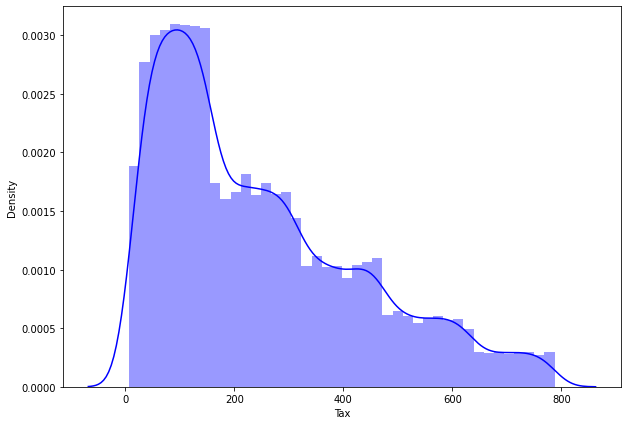

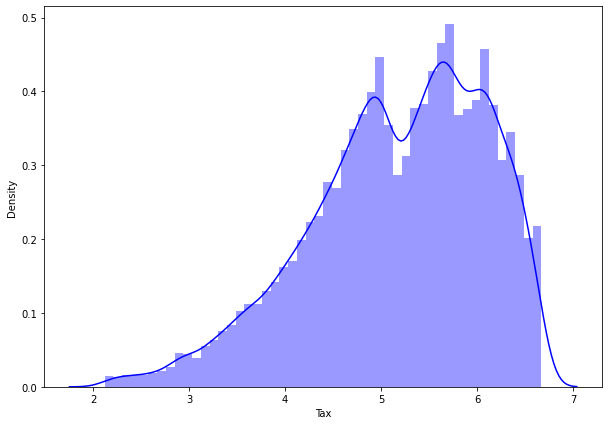

In [84]:
## 양자화 (binning)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
sns.distplot(df["Tax"], color="blue", label="TAX")
plt.show()

plt.figure(figsize = (10,7))
sns.distplot(np.log(1+df["Tax"]), color="blue", label="Log TAX")
plt.show()

In [86]:
# 로그 변환 이전과 후의 분산 비교
print('로그 변환 전 :',df.Tax.var())
print('로그 변환 후 :',np.log(df.Tax).var())

로그 변환 전 : 35035.518547390246
로그 변환 후 : 0.8544926152799767


-----

## KNN을 활용한 결측값 대체

In [3]:
import numpy as np
from sklearn import impute

# 1 에서 15 사이의 값을 가지는 10 개의 행, 6 개의 열로 구성된 랜덤 데이터 생성
X = np.random.randint(1, 15, (10, 6))

# 데이터 타입을 실수형으로 변경한다.
X = X.astype(float)

# 랜덤하게 10 개의 값을 NaN 으로 변경한다.
X.ravel()[np.random.choice(X.size, 10, replace=False)] = np.nan

# kNN 을 사용하여 결측 값을 대치한다.
knn_imputer = impute.KNNImputer(n_neighbors=2)
knn_imputer.fit_transform(X)

array([[ 6.5,  8. , 11. , 12. ,  7. ,  2. ],
       [ 7. ,  6. , 10. , 13. ,  4. ,  3. ],
       [ 6. ,  1. , 12. , 14. , 12. , 11. ],
       [14. , 12. , 12. ,  9. ,  5. ,  7. ],
       [ 2. , 10. ,  1. ,  2. ,  2. ,  6. ],
       [ 6. , 10. ,  7. ,  9. ,  4. ,  5. ],
       [ 3. ,  4. , 12. ,  3. ,  8. ,  3. ],
       [ 6. ,  2. , 11. ,  8. ,  2. ,  1. ],
       [ 8. ,  9. ,  7. ,  6. , 14. ,  5. ],
       [ 8. ,  9.5,  4. ,  5. ,  9. ,  7. ]])